In [252]:
import yfinance as yf
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import helpers
import importlib
import time

from helpers import OverNightStrategy

In [378]:
# Reload modules to avoid a kernel restart
importlib.reload(helpers);
from helpers import OverNightStrategy

In [1577]:
tickers = helpers.get_all_tickers_from_dir()

In [50]:
# Or get tickers based on market cap
tickers = helpers.get_tickers_with_market_cap_limit(0, 1)

### Backtesting the overnight strategy with N best stocks

In [53]:
estimate_trading_cost("ISS.CO")

0.012478851699967123

In [512]:
tc = []

for ticker in tickers:
    print(ticker, end="\r")
    tc.append([ticker, estimate_trading_cost(ticker, trade_size_dkk=10_000)])

In [513]:
df = pd.DataFrame(tc).set_index(0)
df.columns = ["pct_of_median"]

In [522]:
df['liquid'] = df['pct_of_median'] < 0.1

In [524]:
liquid_tickers = tuple(df[df['liquid']==True].index)

In [533]:
# Optimal parameters: array([0.11898536, 5.7745474 , 5.34560856])
#strat = OverNightStrategy(tickers, signal_sample_period_days=5, fee_pr_day=0.00035)
strat = OverNightStrategy(liquid_tickers, signal_sample_period_days=6, exp_signal=True, alpha=0.111, fee_pr_day=0.00035)
#strat = OverNightStrategy(tickers, signal_sample_period_days=20, fee_pr_day=0.001)

In [540]:
strat.compute_portfolio(number_of_stocks_in_portfolio=6, portfolio_weight_type=None)
strat.compute_portfolio_stats(print_stats=True);

Ann. return: 177.7%, Ann. std: 19.3%, Sharpe: 9.18, Beta: 0.26


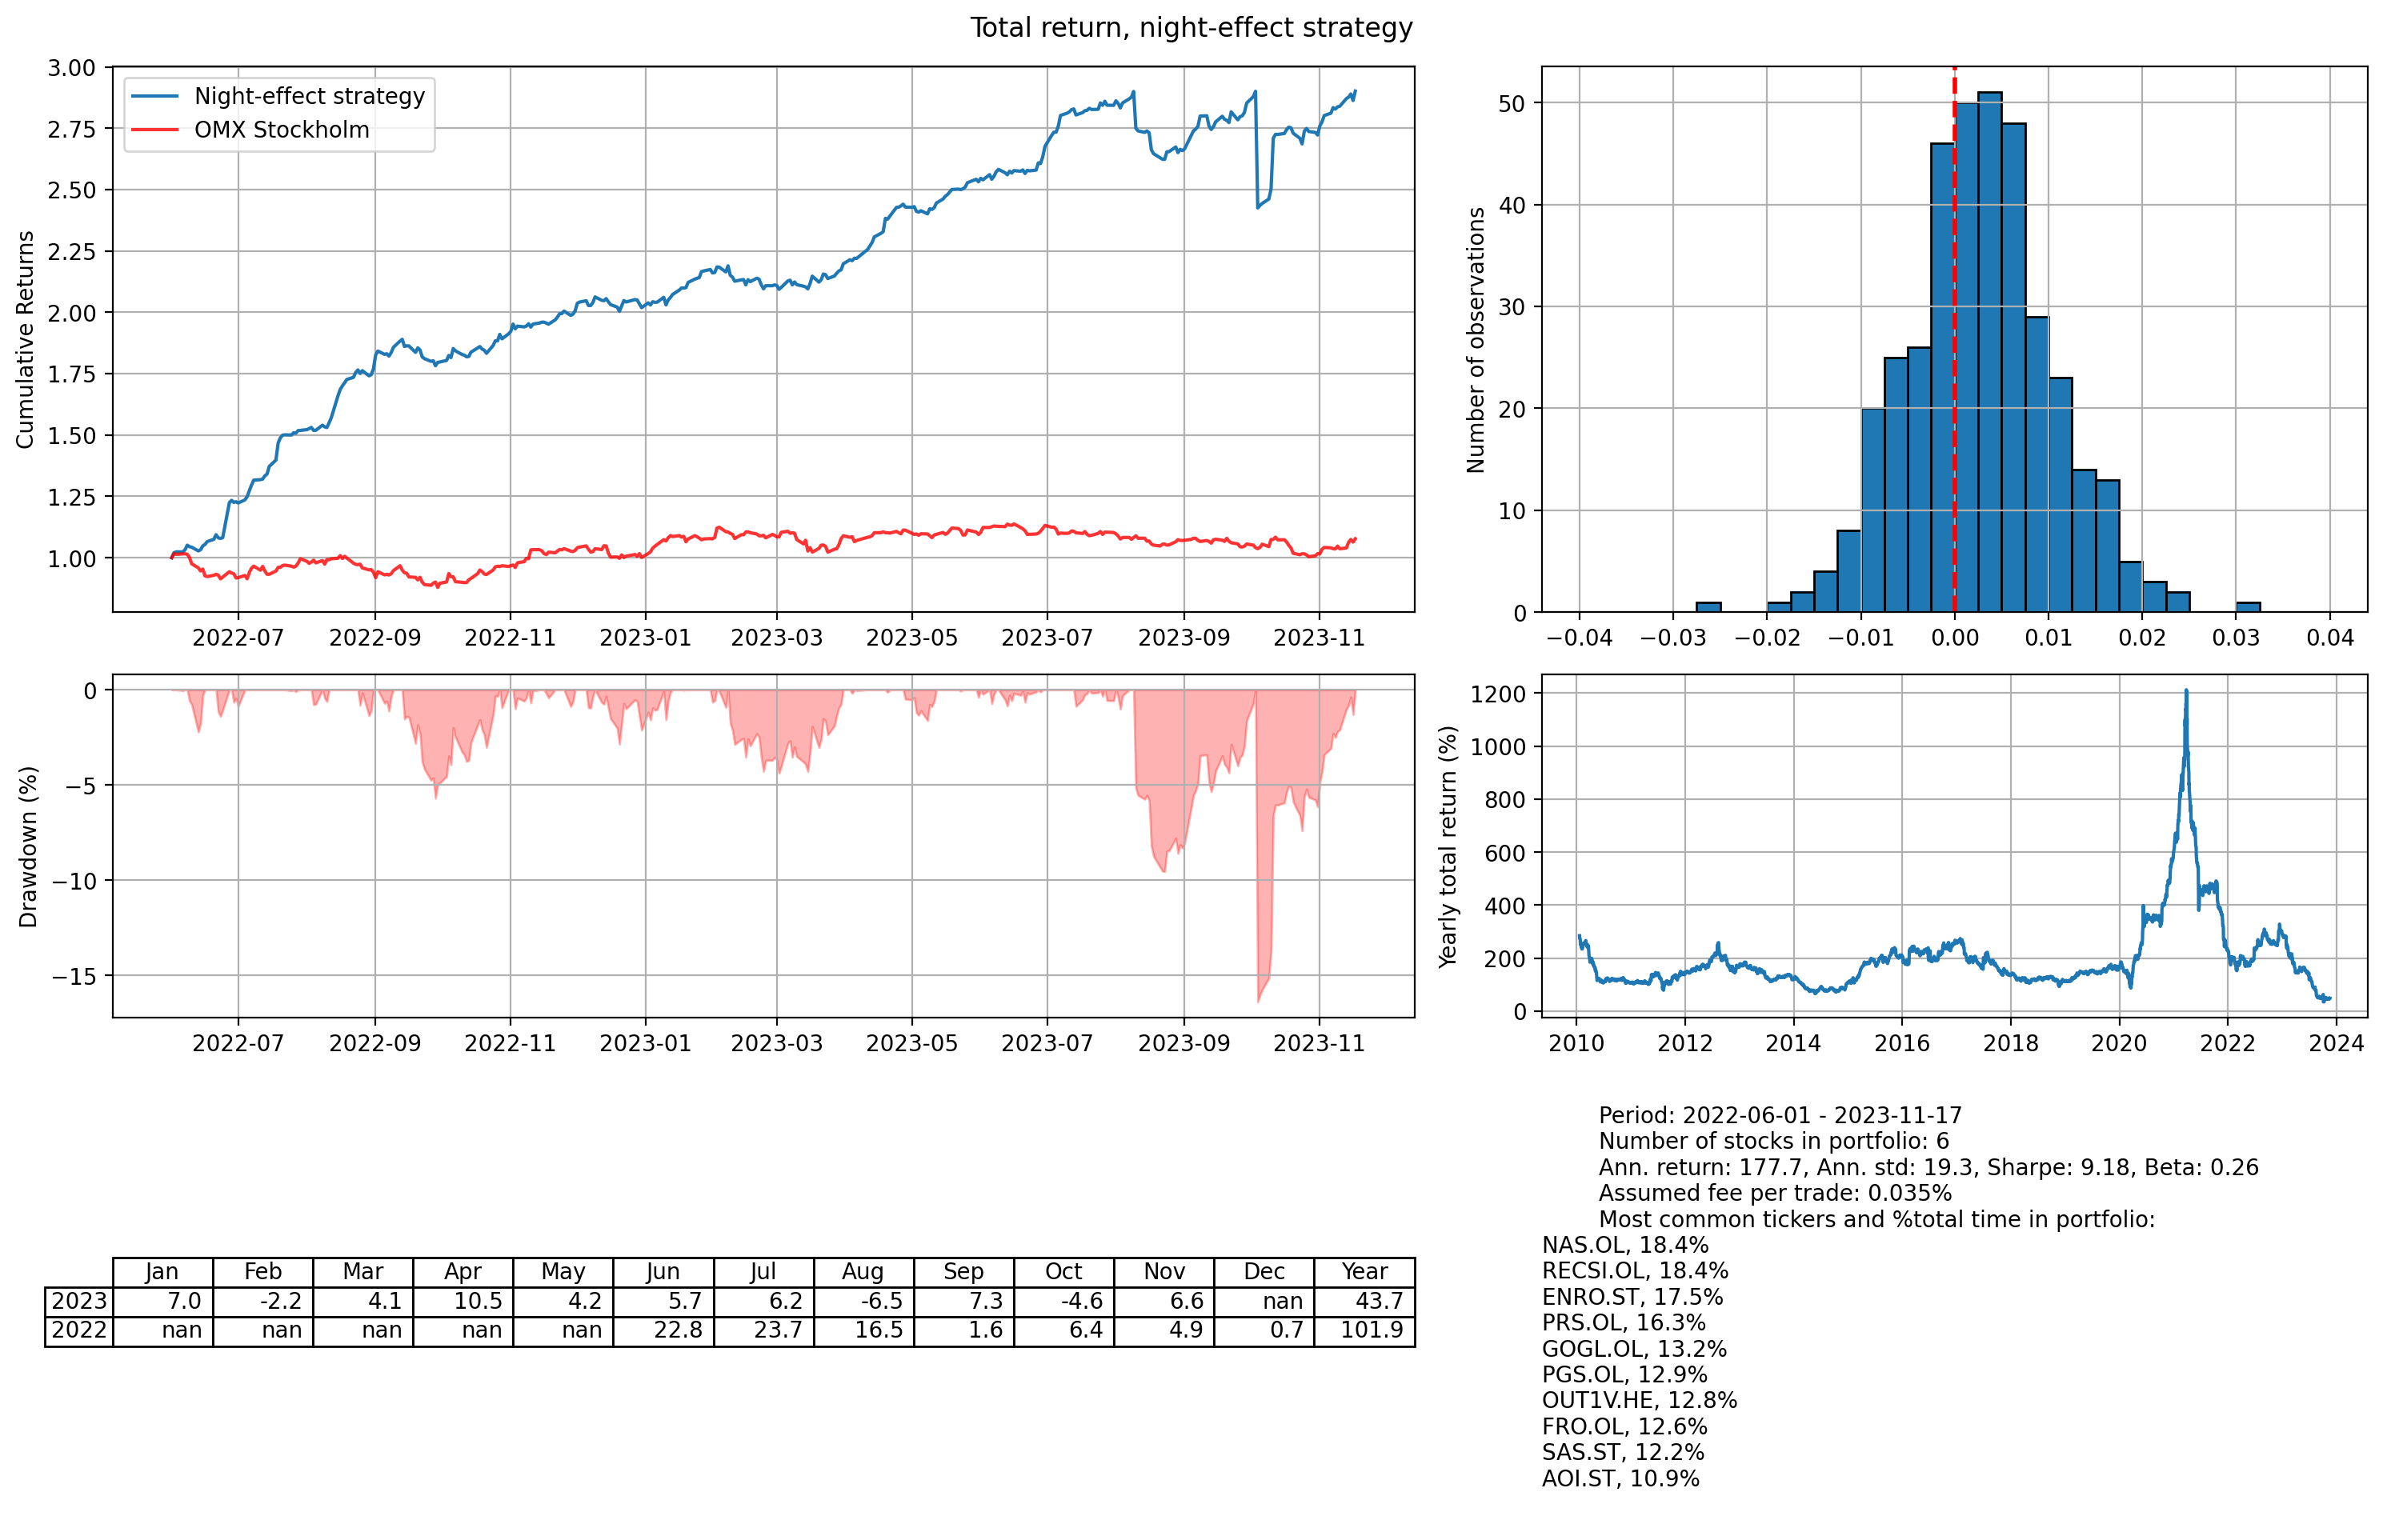

In [541]:
strat.plot_performance(log=False, start_date=dt.date(2022, 6, 1))
#strat.plot_performance(log=True)

(0.0, 1.0, 0.0, 1.0)

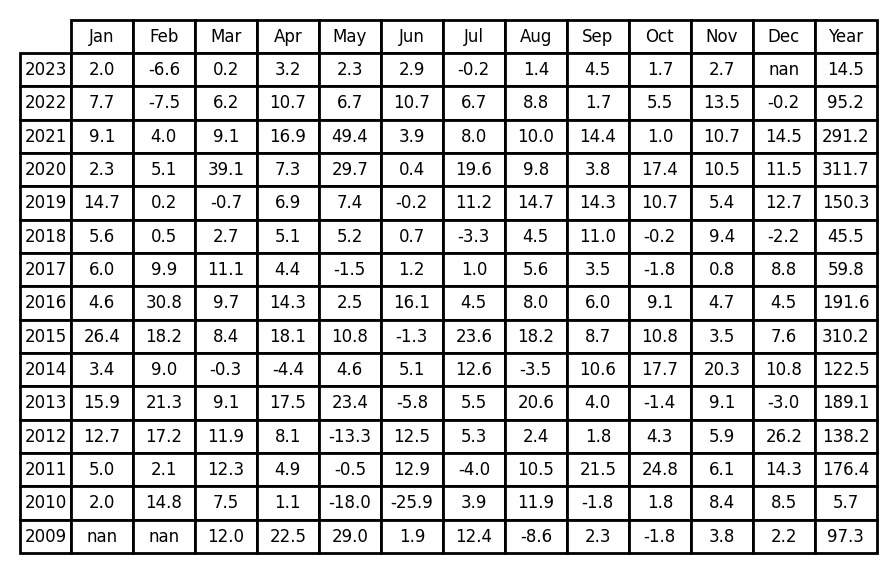

In [1305]:
import calendar

def get_heatmap_colors(df):
        # Choose a diverging colormap
        cmap = plt.cm.RdYlGn

        # Normalize the values
        norm = plt.Normalize(df.values.min(), df.values.max())

        # Get colors based on the normalized values
        colors = [cmap(norm(val)) for val in df.values.flatten()]

        # Reshape the colors to match the shape of the DataFrame
        return [colors[i:i+len(df.columns)] for i in range(0, len(colors), len(df.columns))]


fig, ax = plt.subplots(dpi=200, figsize=(4, 1))
pivot_table = strat.monthly_returns.apply(pd.to_numeric, errors='coerce')

df_year = pd.concat([strat.cum_returns.iloc[[0]], strat.cum_returns.resample("Y").last()]).pct_change().multiply(100).iloc[1:]
df_year.index = df_year.index.year
df_year = df_year.sort_index(ascending=False)
pivot_table = pd.concat([pivot_table, df_year], axis=1, ignore_index=True)
pivot_table = pivot_table.applymap(lambda x: f'{x:.1f}')
pivot_table = pivot_table.replace(np.nan, "")

colLabels = [calendar.month_abbr[i] for i in range(1, 13)] + ["Year"]

tab = ax.table(cellText=pivot_table.values,
                rowLabels=pivot_table.index,
                loc='center',
                cellLoc='center',
                colLabels=colLabels,
                colWidths=[0.1]*len(pivot_table.columns))

ax.axis('off')

### Optimizing for best sharpe ratio

In [470]:
sample_periods = range(1, 11)
skews = [a/10 for a in range(10, 51, 5)]
res = np.empty((len(sample_periods), len(skews)))
for i, period in enumerate(sample_periods):    
    for j, skew in enumerate(skews):
        strat = OverNightStrategy(liquid_tickers, signal_sample_period_days=period,
                                  exp_signal=num_stocks, alpha=0.15, fee_pr_day=0.00035, skew_factor=skew)
        strat.compute_portfolio(number_of_stocks_in_portfolio=8, portfolio_weight_type="skewed")
        strat.compute_portfolio_stats(print_stats=False)
        res[i, j] = strat.sharpe
        print(i,j, end="\r")

In [471]:
sharpes = pd.DataFrame(res, columns=skews)

In [472]:
sharpes

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,6.42,6.41,6.40,6.39,6.37,6.36,6.34,6.32,6.30
1,6.39,6.38,6.37,6.35,6.34,6.32,6.30,6.29,6.27
2,6.41,6.40,6.39,6.37,6.36,6.34,6.32,6.30,6.28
3,6.41,6.40,6.38,6.37,6.36,6.34,6.32,6.30,6.28
4,6.41,6.40,6.39,6.37,6.36,6.34,6.32,6.30,6.29
5,6.38,6.37,6.36,6.34,6.33,6.31,6.29,6.27,6.25
6,6.38,6.37,6.35,6.34,6.32,6.31,6.29,6.27,6.25
7,6.37,6.36,6.35,6.33,6.32,6.30,6.28,6.26,6.25
8,6.36,6.34,6.33,6.32,6.30,6.28,6.27,6.25,6.23
9,6.34,6.32,6.31,6.30,6.28,6.27,6.25,6.23,6.21


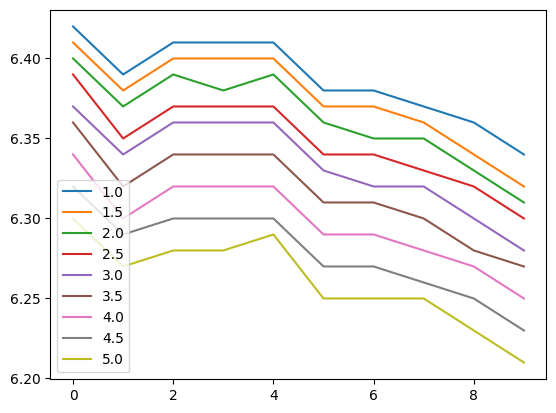

In [473]:
# Plot each column separately and add to the legend
for column in sharpes.columns:
    plt.plot(sharpes.index, sharpes[column], label=column)

# Add legend
plt.legend()

# Show the plot
plt.show()

## Trying to use minimize

In [531]:
from scipy.optimize import minimize

def objective_function(params):
    # Extract parameters and calculate signal
    alpha, period, num_stocks = params
    strat = OverNightStrategy(liquid_tickers, signal_sample_period_days=int(period),
                              exp_signal=num_stocks, alpha=alpha, fee_pr_day=0.00035)
    strat.compute_portfolio(number_of_stocks_in_portfolio=int(num_stocks), portfolio_weight_type=None)
    strat.compute_portfolio_stats(print_stats=False)
    return -strat.sharpe  # Minimize, so negate the performance metric

# Initial guess for parameters
initial_params = [0.1, 5, 20]

# Optimize
result = minimize(objective_function, x0=initial_params, method='Nelder-Mead', bounds=[(0.01, 0.99), (1, 900), (1, 40)])
optimal_params = result.x